# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

# Описание проекта  
Заказчик этого исследования — сеть отелей «Как в гостях».   
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.  
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.  

# Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.  
  
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.  
  
Стоимость номеров отеля:  
категория A: за ночь — 1 000, разовое обслуживание — 400;  
категория B: за ночь — 800, разовое обслуживание — 350;  
категория C: за ночь — 600, разовое обслуживание — 350;  
категория D: за ночь — 550, разовое обслуживание — 150;  
категория E: за ночь — 500, разовое обслуживание — 150;  
категория F: за ночь — 450, разовое обслуживание — 150;  
категория G: за ночь — 350, разовое обслуживание — 150    
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.  
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно  окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.  

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn import set_config
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

In [3]:
#Взглянем на наши данные
display(df_train.head())
display(df_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [4]:
#Отобразим инфо по нашим данным
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
#Проверим на наличие явных дубликатов
print(df_train.duplicated().value_counts())
print(df_test.duplicated().value_counts())

False    65229
dtype: int64
False    32412
dtype: int64


Явных дубликатов у нас нет.

In [6]:
#Првоерим на кол-во пропусков
df_train.isnull().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [7]:
#Првоерим на кол-во пропусков
df_test.isnull().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Удалим лишние пробелы в столбцах.

In [8]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_train['meal'] = df_train['meal'].str.strip()
df_test['meal'] = df_test['meal'].str.strip()

Данные чистые , попробуем теперь избавиться от аномальных бронирований


Дети не могут забронировать отель без взрослых , узнаем это

In [9]:
df_train.query('(children > 0 | babies > 0) & adults == 0').shape[0]

151

In [10]:
#Удалим такие значения
df_train.drop(df_train.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)
df_test.drop(df_test.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)

Проверим типы данных.

In [11]:
df_train.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

In [12]:
df_test.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

In [13]:
# uint8 колонки
uint8_columns = [
    'is_canceled', 'arrival_date_day_of_month',
    'stays_in_week_nights', 'adults', 'children',
    'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'
]

# uint16 колонки
uint16_columns = ['lead_time', 'days_in_waiting_list']

# category колонки
category_columns = [
    'arrival_date_year', 'arrival_date_month', 'meal', 'country',
    'distribution_channel', 'reserved_room_type', 'customer_type'
]

# изменяем dtypes колонок
df_train = df_train.astype({
    **{_:'uint8' for _ in uint8_columns},
    **{_:'uint16' for _ in uint16_columns},
    **{_:'category' for _ in category_columns}
})

df_test = df_test.astype({
    **{_:'uint8' for _ in uint8_columns},
    **{_:'uint16' for _ in uint16_columns},
    **{_:'category' for _ in category_columns}
})


Удалим столбец id , так как он нам дальше не понадобиться

In [14]:
df_train.drop(columns='id', inplace=True)
df_test.drop(columns='id', inplace=True)

Посмотрим визуально кол-во отказов.

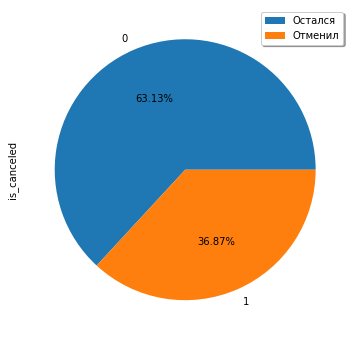

In [15]:
df_train['is_canceled'].value_counts().plot.pie(legend=True, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отменил'], shadow=True)
plt.show()

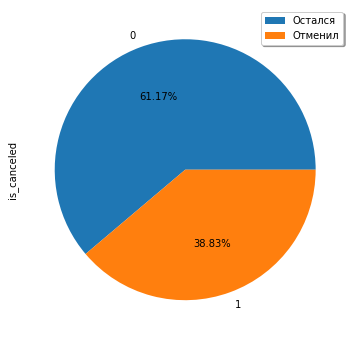

In [16]:
df_test['is_canceled'].value_counts().plot.pie(legend=True, autopct='%1.2f%%', figsize=(12,6))
plt.legend(['Остался', 'Отменил'], shadow=True)
plt.show()

Не большой дисбаланс целевого признака есть, хотя он не является критичным.При обучении применим гиперпараметр class_weight='balanced'.

Посмотрим на corr признаков.

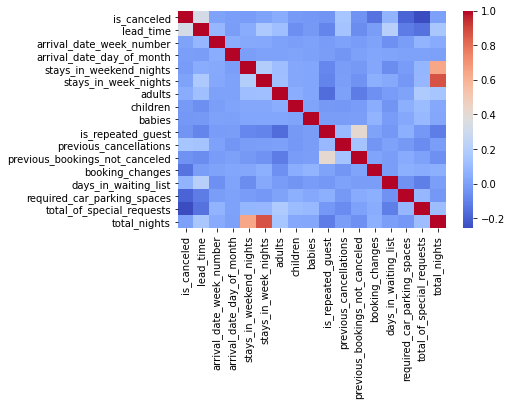

In [17]:

sns.heatmap(df_train.corr(), cmap= 'coolwarm');

Нам удалось увидеть высокий уровень корреляции между колонками total_nights и stays_in_week_nights, stays_in_weekend_nights, что вполне логично, т к эти колонки описывают по-сути, одни и те же данные - количество ночей. previous_bookings_not_canceled и is_repeated_guest т е речь идет о постоянных клиентах - они бронируют номера и есть признак, что делают это более одного раза => эта группа клиентов менее подвержена отказу от брони. Довольно высокая корреляция между is_canceled и lead_time - чем раньше забронировал номер, тем выше вероятность отказа от номера - все логично, т к жизненные обстоятельства меняются.Корреляция между is_canceled и previous_cancellations говорит нам о том, что заказы чаще отменяются у людей, которые до этого отменяли заказы. Корреляция между is_canceled и days_in_waiting_list также подтверждает ситуацию с тем, что если заказ не подтвержден в течении суток (выяснили выше), высока вероятность отмены. Также обращает на себя внимание взаимосвязь между, ранним бронированием (lead_time) и поздним подтверждением (days_in_waiting_list) тем дольше заказ ожидает подтверждения - это и есть те люди, которые не получив подтверждения быстро, ушли к конкурентам! Менеджменту стоит призадуматься относительно цепочки создания ценности в сети гостиниц. Корреляция между stays_in_week_nights и adults говорит нам о том, что на выходные гостиницу бронируют преимущественно взрослые люди )).

In [18]:
df_train.drop(columns='stays_in_weekend_nights', inplace=True)
df_test.drop(columns='stays_in_weekend_nights', inplace=True)

В столбце required_car_parking_spaces отбросим значения выше 1.

In [19]:
df_train.drop(df_train[df_train['required_car_parking_spaces'] > 1].index, inplace=True)
df_test.drop(df_test[df_test['required_car_parking_spaces'] > 1].index, inplace=True)

Ресетним индексы , так как мы удаляли некоторые дначения.

In [20]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

### Вывод

Мы загрузили данные, ознакомились с ними.  
В наших данных нет пропусков , нет дубликатов, все типы данных подходят каждому столбцу.  
Удалили лишние пробелы в столбцах.  
Удалили не нужный нам столбец id.  
Избавились от аномальных бронирований.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Создадим словари со стоимостью ночи и уборки , а так же сезонности

In [21]:
price = {
    'A':[1000, 400],
    'B':[800, 350],
    'C':[600, 350],
    'D':[550, 150],
    'E':[500, 150],
    'F':[450, 150],
    'G':[350, 150]
}

season = {
    'January':1,
    'February':1,
    'March':1.2,
    'April':1.2,
    'May':1.2,
    'June':1.4,
    'July':1.4,
    'August':1.4,
    'September':1.2,
    'October':1.2,
    'November':1.2,
    'December':1    
}

In [22]:
def income(row, refuse=False):
    
    '''
    Функция вычисляет доход по каждой строке, в зависимости от типа комнаты, длительности проживания.
    С учётом сезонности и обслуживания номеров.
    Если появляется столбец с предсказаниями - учитывает возможность удержания залога при отмене брони.
    Если параметр refuse == True - вводит поправку на доход от очередного клиента - 50%.
    '''
    # введём поправку на отказником
    if refuse:
        ref_mod = 0.5
    else:
        ref_mod = 1
    
    # вычислим количество уборок
    if row['total_nights'] % 2 != 0:
        cleanings = 1 + row['total_nights'] // 2
    else:
        cleanings = row['total_nights'] // 2
        
    # вычислим доход
    if 'is_canceled_p' not in list(row.index):
        if row['is_canceled'] == 1:
            return - (price[row['reserved_room_type']][0] * season[row['arrival_date_month']]
                      + price[row['reserved_room_type']][1] * row['total_nights'] // 2)
        else:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings)
    else:
        if row['is_canceled'] == 1 and row['is_canceled_p'] == 0:
            return - (price[row['reserved_room_type']][0] * season[row['arrival_date_month']]
                      + price[row['reserved_room_type']][1] * cleanings)
        elif row['is_canceled'] == 1 and row['is_canceled_p'] == 1:
            return (price[row['reserved_room_type']][0] * season[row['arrival_date_month']] * .8
                    - price[row['reserved_room_type']][1]) * ref_mod
        elif row['is_canceled'] == 0 and row['is_canceled_p'] == 1:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings) * ref_mod            
        else:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings)

In [23]:
df_train['income'] = df_train.apply(income, refuse=True, axis=1)
df_test['income'] = df_test.apply(income, refuse=True, axis=1)

Проверим наши данные.

In [24]:
df_train.head(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,income
0,0,7,2015,July,27,1,1,1,0,0,...,0,0,A,0,0,Transient,0,0,1,1000.0
1,0,14,2015,July,27,1,2,2,0,0,...,0,0,A,0,0,Transient,0,1,2,2400.0
2,0,0,2015,July,27,1,2,2,0,0,...,0,0,C,0,0,Transient,0,0,2,1330.0
3,0,9,2015,July,27,1,2,2,0,0,...,0,0,C,0,0,Transient,0,1,2,1330.0
4,1,85,2015,July,27,1,3,2,0,0,...,0,0,A,0,0,Transient,0,1,3,-2000.0
5,1,75,2015,July,27,1,3,2,0,0,...,0,0,D,0,0,Transient,0,0,3,-995.0
6,1,23,2015,July,27,1,4,2,0,0,...,0,0,E,0,0,Transient,0,0,4,-1000.0
7,0,18,2015,July,27,1,4,2,1,0,...,0,0,G,1,0,Transient,0,1,4,1660.0
8,0,68,2015,July,27,1,4,2,0,0,...,0,0,D,0,0,Transient,0,3,4,2780.0
9,0,37,2015,July,27,1,4,2,0,0,...,0,0,E,0,0,Contract,0,0,4,2500.0


Посчитали прибыль отеля для каждой записи

### Шаг 4. Разработка модели ML

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.  
Поскольку данные не сильно дисбалансированы, будем использовать метрики F1, Accuracy, матрицу ошибок, Precision, Recall и прибыль.  
Чтобы не дать моделям максимизировать прибыль ценой задирания метрики FP, которая модет привести к вторичному падению доходов за счёт передумавших клиентов, для выбора лучших гиперпараметров будем использовать гармоническое среднее F1   
Оценим прибыль, которую принесёт выбранная модель за последний год.    

Напишем функцию оценки прибыли для применения в подборе параметров кросс-валидацией при поиске по сетке.

In [25]:
def income_scorer(est, X, y, df=df_train, refuse=False):
    '''
    Функция оценки разницы прибыли для поиска гиперпараметров по сетке.
    '''
    # получим предсказанные значения столбца is_canceled_p
    y_pred = pd.Series(est.predict(X), index=X.index, name='is_canceled_p')

    # добавим предсказанные значения к признакам
    df = df.iloc[X.index].join(y_pred)
    
    # вычислим прибыль
    df['income'] = df.apply(income, refuse=refuse, axis=1)
    
    return df['income'].sum() / 1e6

Разделим обучающие и тестовые данные на features(X) и target(y).

In [26]:
X = df_train.drop(['is_canceled', 'income'], axis=1)
y = df_train['is_canceled']
X_test = df_test.drop(['is_canceled', 'income'], axis=1)
y_test = df_test['is_canceled']

Найдём результаты для случайной и константной моделей.

In [27]:
model_dc = DummyClassifier(strategy='uniform', random_state=1234)
model_dc.fit(X, y)
prediction_dc = model_dc.predict(X)

f1 = f1_score(y, prediction_dc).round(decimals=3)
print(f'Метрика F1 на случайной модели составила {f1}')
accuracy = accuracy_score(y, prediction_dc).round(decimals=3)
print(f'Метрика Accuracy на случайной модели составила {accuracy}')
precision = precision_score(y, prediction_dc).round(decimals=3)
print(f'Метрика Precision на случайной модели составила {precision}')
recall = recall_score(y, prediction_dc).round(decimals=3)
print(f'Метрика Recall на случайной модели составила {recall}')
score = income_scorer(model_dc, X, y, df_train).round(decimals=3)
print(f'Прибыль за 2017 год составила {score} млн. рублей')
score_mod = income_scorer(model_dc, X, y, df_train, refuse=True).round(decimals=3)
print(f'Прибыль с учётом модификатора отказа за 2017 год составила {score_mod} млн. рублей')

Метрика F1 на случайной модели составила 0.423
Метрика Accuracy на случайной модели составила 0.499
Метрика Precision на случайной модели составила 0.368
Метрика Recall на случайной модели составила 0.498
Прибыль за 2017 год составила 92.928 млн. рублей
Прибыль с учётом модификатора отказа за 2017 год составила 62.755 млн. рублей


In [28]:
tn, fp, fn, tp = confusion_matrix(y, prediction_dc).ravel()
(tn, fp, fn, tp)

(20483, 20587, 12034, 11962)

Занесём результаты в сводную таблицу.

In [29]:
results_table = {}
results_table['DummyClassifierRandom'] = [f1, accuracy, tn, fp, fn, tp, precision, recall, score, score_mod]

Видно, что даже случайная модель даёт в сценарии с введением депозитов прирост выручки за счёт случайно совпавших предсказаний с реальной отменой TP. Но случайная модель даёт много ложно положительных FP что в итоге приводит к падению общего дохода с учётом модификатора отказа.  

Проверим так же константную модель.



In [30]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc_mf.fit(X, y)
prediction_dc_mf = model_dc_mf.predict(X)

f1 = f1_score(y, prediction_dc_mf)
print(f'Метрика F1 на константной модели составила {f1}')
accuracy = accuracy_score(y, prediction_dc_mf).round(decimals=3)
print(f'Метрика Accuracy на константной модели составила {accuracy}')
precision = precision_score(y, prediction_dc_mf).round(decimals=3)
print(f'Метрика Precision на случайной модели составила {precision}')
recall = recall_score(y, prediction_dc_mf).round(decimals=3)
print(f'Метрика Recall на случайной модели составила {recall}')
score = income_scorer(model_dc_mf, X, y, df_train).round(decimals=3)
print(f'Прибыль за 2017 год составила {score} млн. рублей')
score_mod = income_scorer(model_dc_mf, X, y, df_train, refuse=True).round(decimals=3)
print(f'Прибыль с учётом модификатора отказа за 2017 год составила {score_mod} млн. рублей')

Метрика F1 на константной модели составила 0.0
Метрика Accuracy на константной модели составила 0.631
Метрика Precision на случайной модели составила 0.0
Метрика Recall на случайной модели составила 0.0
Прибыль за 2017 год составила 65.557 млн. рублей
Прибыль с учётом модификатора отказа за 2017 год составила 65.557 млн. рублей


Создадим функцию для оценки метрик моделей.

In [31]:
def model_score(estimator):
    
    '''
    Функция вывода отчёта по результатам подбора гиперпараметров выбранной модели.
    '''
    
    # основные метрики
    f1 = f1_score(y, estimator.predict(X)).round(decimals=3)
    print(f'Метрика F1 составила {f1}')
    accuracy = accuracy_score(y, estimator.predict(X)).round(decimals=3)
    print(f'Метрика Accuracy составила {accuracy}')
    precision = precision_score(y, estimator.predict(X)).round(decimals=3)
    print(f'Метрика Precision составила {precision}')
    recall = recall_score(y, estimator.predict(X)).round(decimals=3)
    print(f'Метрика Recall составила {recall}')
    income_score = income_scorer(estimator, X, y, df_train).round(decimals=3)
    print(f'Доход за 2017 год составил {income_score} млн. рублей')
    income_score_mod = income_scorer(estimator, X, y, df_train, refuse=True).round(decimals=3)
    print(f'Доход с учётом модификатора отказа за 2017 год составил {income_score_mod} млн. рублей')
    
    # матрица ошибок
    display(pd.DataFrame(
        [confusion_matrix(y, estimator.predict(X)).ravel().tolist(),
         confusion_matrix(y, prediction_dc).ravel().tolist()],
        columns=['TN', 'FP', 'FN', 'TP'],
        index=['Для оцениваемой модели', 'Для случайной модели']
    ))
    tn, fp, fn, tp = confusion_matrix(y, estimator.predict(X)).ravel()
    
    # занесём результаты в сводную таблицу
    result = pd.DataFrame(estimator.cv_results_)
    display(result.loc[result['rank_test_f1'] == 1])
    
    return None

### Модель RandomForest

Создадим трансформер для различных колонок, в случае с "деревянными моделями" к категориальным применим OE, числовые оставим как есть.

In [32]:
ensemble_transformer = make_column_transformer(
    (OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include='category')
    ),
    remainder='passthrough'
)

Создадим pipeline для классификатора RandomForestClassifier().

In [33]:
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestClassifier(
        random_state=12345,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    )
)

Зададим сетку параметров и создадим estimator.

In [34]:
param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_depth':np.arange(1, 10, 1),
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy', 'precision':'precision', 'recall':'recall'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [35]:
%time 
gs_rf.fit(X, y)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f68fcac6ac0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(...ht='balanced',
                                                               n_jobs=-1,
                                                

Посмотрим на результаты обучения.

In [36]:
pd.DataFrame(gs_rf.cv_results_)[[
    'param_randomforestclassifier__max_depth', 'param_randomforestclassifier__n_estimators',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_precision', 'rank_test_precision',
    'mean_test_recall', 'rank_test_recall',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_income_scorer,rank_test_income_scorer
0,1,100,0.598366,1,0.708464,2,0.598501,3,0.610016,1,20.092330,1
1,1,150,0.572649,7,0.681615,6,0.558145,16,0.598266,2,19.919571,2
2,2,100,0.589696,3,0.710047,1,0.609854,1,0.586682,12,19.795918,12
3,2,150,0.591853,2,0.706605,3,0.600460,2,0.596641,4,19.895501,5
4,3,100,0.575975,5,0.690712,5,0.593895,4,0.587932,11,19.810453,11
5,3,150,0.581489,4,0.691988,4,0.591844,5,0.598058,3,19.916931,3
6,4,100,0.571039,8,0.676158,8,0.583641,7,0.595517,5,19.902174,4
7,4,150,0.573363,6,0.680308,7,0.586027,6,0.595058,6,19.889565,6
8,5,100,0.560288,12,0.664247,12,0.568010,11,0.591057,9,19.832098,9
9,5,150,0.561730,11,0.667213,11,0.571324,10,0.589474,10,19.818631,10


In [37]:
model_score(gs_rf)

Метрика F1 составила 0.69
Метрика Accuracy составила 0.775
Метрика Precision составила 0.702
Метрика Recall составила 0.678
Доход за 2017 год составил 103.955 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 89.896 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,34160,6910,7732,16264
Для случайной модели,20483,20587,12034,11962


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_income_scorer,split1_test_income_scorer,split2_test_income_scorer,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.920828,0.021658,0.603094,0.017323,1,100,"{'randomforestclassifier__max_depth': 1, 'rand...",21.335426,21.306962,16.479762,...,0.088638,3,0.659583,0.540529,0.510731,0.415086,0.924151,0.610016,0.175397,1


### Модель LogisticRegression()

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [38]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include='category')
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.



In [39]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=12345,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [40]:
param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [41]:
%time gs_lr.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 7min 21s, sys: 1.78 s, total: 7min 22s
Wall time: 7min 23s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f68fca9ae50>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_colum...
                                        LogisticRegression(class_weight='balanced',
  

Проверим результаты.

In [42]:
pd.DataFrame(gs_lr.cv_results_)[[
    'param_logisticregression__C', 'param_logisticregression__max_iter',
    'param_logisticregression__solver',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__solver,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_income_scorer,rank_test_income_scorer
0,0.001,500,newton-cg,0.559234,7,0.651029,3,19.995098,9
1,0.001,500,lbfgs,0.559353,3,0.651091,1,19.996830,7
2,0.001,500,liblinear,0.559243,5,0.645082,7,20.092917,3
3,0.001,500,sag,0.559896,2,0.647909,6,20.062014,5
4,0.001,500,saga,0.559000,10,0.644221,10,20.101146,1
5,0.001,1000,newton-cg,0.559234,7,0.651029,3,19.995098,9
6,0.001,1000,lbfgs,0.559353,3,0.651091,1,19.996830,7
7,0.001,1000,liblinear,0.559243,5,0.645082,7,20.092917,3
8,0.001,1000,sag,0.560500,1,0.649523,5,20.048477,6
9,0.001,1000,saga,0.559002,9,0.644405,9,20.097472,2


In [43]:
model_score(gs_lr)

Метрика F1 составила 0.72
Метрика Accuracy составила 0.783
Метрика Precision составила 0.686
Метрика Recall составила 0.757
Доход за 2017 год составил 107.747 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 91.632 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,32774,8296,5841,18155
Для случайной модели,20483,20587,12034,11962


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__solver,params,split0_test_income_scorer,split1_test_income_scorer,...,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
8,21.361048,2.815785,0.498881,0.022,0.001,1000,sag,"{'logisticregression__C': 0.001, 'logisticregr...",20.956226,21.1337,...,0.075174,1,0.771938,0.651425,0.651502,0.592254,0.580496,0.649523,0.067878,5


Найдем лучший индекс интерации.

In [44]:
gs_lr.best_index_

8

Найдем лучшии гиперпараметры данной модели.

Посмотрим на сводную таблицу с результатами.

In [45]:
pd.DataFrame(
    results_table, index=[
        'F1', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'Income_score', 'Income_score_mod'
    ]
).transpose()

,F1,Accuracy,TN,FP,FN,TP,Precision,Recall,Income_score,Income_score_mod
DummyClassifierRandom,0.423,0.499,20483.0,20587.0,12034.0,11962.0,0.368,0.498,92.928,62.755


Более сбалансированная модель Случайный лес , хоть и логистическая регрессия показала наибольшую прибыль.  
Проверим результаты RandomForest на тестовой выборке.

In [46]:
def model_score_end(estimator):
    
    '''
    Функция вывода отчёта по результатам подбора гиперпараметров выбранной модели.
    '''
    
    # основные метрики
    f1 = f1_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика F1 составила {f1}')
    accuracy = accuracy_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Accuracy составила {accuracy}')
    precision = precision_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Precision составила {precision}')
    recall = recall_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Recall составила {recall}')
    income_score = income_scorer(estimator, X_test, y_test, df_test).round(decimals=3)
    print(f'Доход за 2017 год составил {income_score} млн. рублей')
    income_score_mod = income_scorer(estimator, X_test, y_test, df_test, refuse=True).round(decimals=3)
    print(f'Доход с учётом модификатора отказа за 2017 год составил {income_score_mod} млн. рублей')

In [47]:
model_score_end(gs_rf)

Метрика F1 составила 0.573
Метрика Accuracy составила 0.729
Метрика Precision составила 0.737
Метрика Recall составила 0.469
Доход за 2017 год составил 45.441 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 40.952 млн. рублей


Проверим тестовую выборку на Логистической регрессии

In [48]:
model_score_end(gs_lr)

Метрика F1 составила 0.669
Метрика Accuracy составила 0.753
Метрика Precision составила 0.699
Метрика Recall составила 0.641
Доход за 2017 год составил 50.281 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 42.747 млн. рублей


Две метрики подходять нам , но я бы остановился на случайном лесе , так как более сбаланситрованная модель.

### Вывод

Все модели машинного обучения показали на тестовой выборке прибыль лучше чем без введения модели оценки вероятности отмены брони и залоговой системы. Даже с учётом негативного прогноза в 50% оттока клиентов, которых система признала ненадёжными.     
Разные модели по-разному балансируют между негативными и позитивными классами. Все модели по метрикам Accuracy и по совокупности оценок матрицы ошибок лучше случайных и константной моделей.  
  
При выборе модели нам следует руководствоваться увеличением потенциальной прибыли (выше TP и ниже FN), но и не стоит забывать о том, что все клиенты которых система вынудит оплачивать залог (FP) могут отказаться от услуг отеля вообще.  
  
С учётом влияния негативного сценария оттока клиентов, признанных системой неблагонадёжными, макссимальную прибыль показала модель LR.

### Шаг 5. Опишите портрет «ненадёжного» клиента

На основе исследовательского анализа данных опишем клиента, склонного к отказу от брони.

Выведем корреляционную матрицу Пирсона.

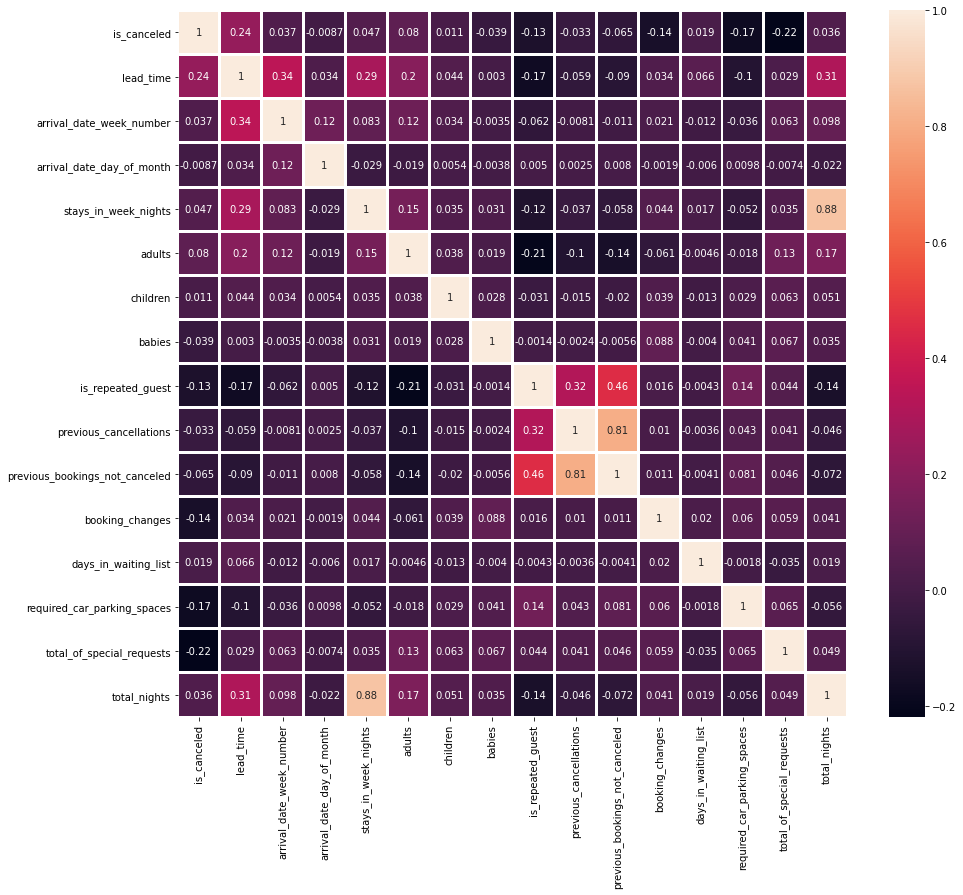

In [49]:
plt.figure(figsize=(15, 13))

sns.heatmap(df_test.drop('income', axis=1).corr(), linewidth=2, annot=True)

plt.show()

Видно что наибольшая зависимость у признака is_canceled от признака lead_time, т.е. чем больше время от бронирования номера до даты заселения, тем выше вероятность отмены.  
  
Обратные зависимости примерно одного порядка есть с признаками is_repeated_guest, booking_changes, required_car_parking_spaces, total_of_special_requests.  
  
Проверим так же как коррелирует вероятность отмены c другими факторами при определённых условиях. Например, при различном количестве младенцев и детей.  

In [50]:
df_train.query('children == 3')['arrival_date_week_number']


4775     34
8717     48
9388      1
11356    14
17475    33
27309    21
30748    31
45868     6
Name: arrival_date_week_number, dtype: int64

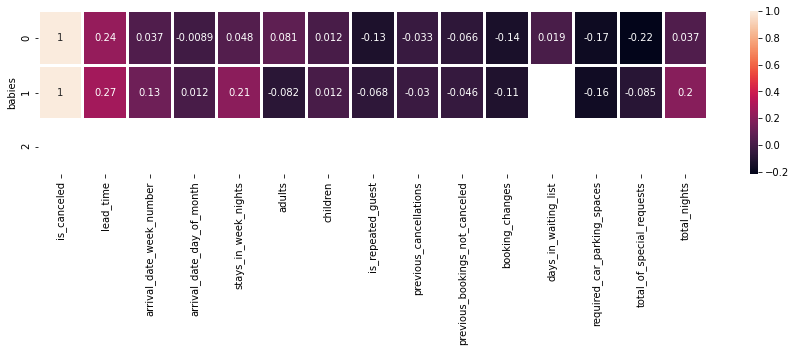

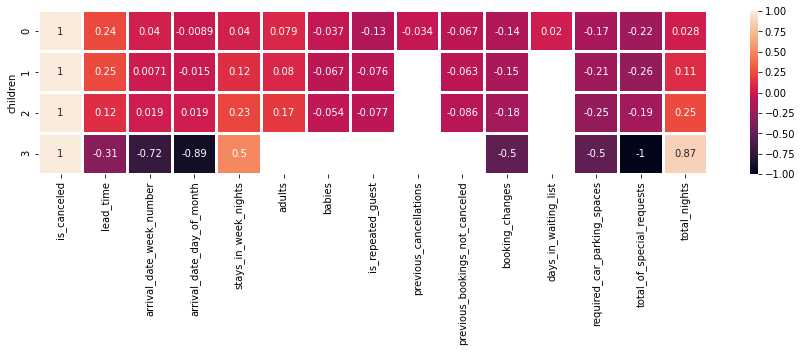

In [51]:
for kids in ['babies', 'children']:
    
    plt.figure(figsize=(15, 3))

    sns.heatmap(df_test.drop('income', axis=1).groupby(kids).corrwith(df_test['is_canceled']), linewidth=2, annot=True)

    plt.show()

Видно что вероятность отказа от брони возрастает в случае с количеством младенцев, падает в зависимости от количества детей. Вероятно, отпуск с младенцами непредсказуем, а с большой семьёй чаще делается в соответствии с планом.  
  
Та же ситуация с неделей заезда. Вероятность отмены отпуска с семьёй с 3мя детьми невелика и наверняка будут дополнительные запросы.  
  
Также с возрастанием количества детей возрастает вероятность отмены при увеличении длительности снятия номера.  
  
В целом эти факторы говорят о том что клиенты которые останавливаются в отеле в первый раз, не вносят в бронь изменений, не бронируют место под машину, не делают специальных запросов и бронируют номер сильно заранее более склонны к отмене и являются "ненадёжными".  

### Шаг 6. Напишите общий вывод

Мы подготовили и очистили данные. Подобрали метрики и написали функции необходимые для решения задачи.  
Сбалансированное решение - модель RandomForestClassifier. 
Я выбрал модель Случайный лес , хоть и в линейной регресси больше доход, но RandomForest более стабильная.
Признак is_repeated_guest хорошо коррелирует одновременно и с previous_cancelations и с previous_bookings_not_canceled, вероятно, речь о бизнес клиентах, для которых характерны частые отмены при изменении планов, но которые предпочитают останавливаться в одном и том же месте. Данные клиенты, зная что вероятность отмены всегда есть, станут фактором снижения доходов от введения системы залогов. Таких клиентов стоит перевести в отдельную категорию, которую не будет касаться система залогов.  
  
Таким образом можно резюмировать что машинное обучение может существенно увеличить выручку при грамотном применении и отбить затраты на введение системы оценки рисков, но при этом настоятельно рекомендуется провести А/В тест и выяснить какой процент от клиентов в действительности откажется от брони если система потребует таковую. Это поможет минимизировать риски и выбрать оптимальную по доходности модель.  